<a href="https://colab.research.google.com/github/karenyxwang/Big_Data_Analytics/blob/master/pandasql%20and%20spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Homework 2
## Due 24 February, 2020 by 10pm
### Worth 150 points in total

For this assignment, we will focus on introducing you to hierarchical data stored in dataframes, graph data and traversing relationships among data. you will learn to use pandasql (cause Pandas are the our favorite animal and data science tool 🐼) and Spark. You will be using spark locally and not really on a cluster for this homework. The next homework will unleash the full power of Spark by deploying it on a cluster.

For the second section of assignment, we will focus on graph data.  Many real-world datasets are, or can be modeled by, graphs (or trees which are special cases of graphs).  Examples include:

* Networks (social networks, the Web, the connectome, the Internet, traffic networks, …)
* Sets of data in which some of the data is more closely connected than other parts of the data (edges may represent weighted similarity or affinity)
* Phylogenetic trees, grammars, etc.

**Before you begin:** 
This homework is longer than the last one so please start early and come to office hours with questions!

**PLEASE READ THE FAQ** as you do this assignment! It's pinned on Piazza and us TA's work really hard to keep it updated with everything you might need to know or anything we might have failed to specify. Writing these HWs and test cases gets tricky since students always end up implementing solutions that we did not anticipate and thus could not have prepared the grader correcty for.

It makes us really sad to tell you that you should've read the FAQ when you come to office hours or post on piazza saying that you've been stuck one part for a really long time. It'll also make you sad when you realize the answer was already sitting there in the FAQ. Please, read it. Also, please read the directions carefully!


### Libraries and Setup Jargon!
Run the following  cells to setup the notebook. When prompted for a selection, select the number that is associated with java 8

In [ ]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jre x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk openjdk-8-jre x11-utils
0 upgraded, 13 newly installed, 0 to remove and 25 not upgraded.
Need to get 6,970 kB of archives.
After this operation, 20.0 MB of additional disk space will be used.
Get

In [ ]:
%%capture
!pip3 install penngrader

from penngrader.grader import *

VERY IMPORTANT : Enter your **8 digit Penn ID** in the student id field below

In [ ]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 15349478

In [ ]:
grader = PennGrader(homework_id = 'CIS545_Spring_2020_HW2', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 15349478

Make sure this correct or we will not be able to store your grade


# Section 1: Stack Exchange Data

## Exploring the Stack Exchange dataset

<img src = "https://cdn.sstatic.net/Sites/stackoverflow/company/img/logos/se/se-logo.png?v=dd7153fcc7fa" width= "600" align ="center"/>

To survive as a student at Penn , you've certainly used Stack Exchange or Stack Overflow, as a source for all your technical queries. Stack Exchange looks a lot like a social network, it has the following pieces of information to tie it all together:


*   Users: All stack exchange users including admins etc. Sad little Penn students are included here.

*   Posts: The questions the users post and any follow ups

*   Comments: As the name suggests, these are comments on posts

*   Votes: Up/Downvotes 

*   Badges: Rewards you earn for being a good samaritan on the stack exchange platform.


For this homework we'll be parsing this data (dumped in XML) into dataframes and relations, and then exploring how to query and assemble the tables into results.  You'll get to exercise your skills in Pandas, SQL, and even something called PandaSQL!

### Dataset Source

We are going to use the XML dataset available at 
[StackExchange Dataset](https://archive.org/details/stackexchange).  

A visual representation of the data and how they are linked together:

<img src="https://i.stack.imgur.com/AyIkW.png">

In [ ]:
### Install required packages
%%capture
!pip3 install lxml
!pip install pandasql
!pip install googledrivedownloader

In [ ]:
import numpy as np
import pandas as pd
import matplotlib

import gc
import time
import warnings

import json # JSON parsing
from lxml import etree # HTML parsing
import time # Time conversions
from lxml import etree # XML Parser
import pandasql as ps #SQL on Pandas Dataframe

import nltk
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Part 1: Steps to load data from Google Drive


We have provided a copy of the "Data Science Stack Exchange" data, which we thought might provide some interesting insights about the very field you are studying!

This is shared in Google Drive because it's (relatively) fast and inexpensive to copy data from GDrive to Colab.  There are multiple files:

* Users.xml:  these are the users of Stack Exchange, including profile info.
* Posts.xml:  these are the posts to Stack Exchange made by users.
* PostHistory.xml: history of posts.
* PostLinks.xml: hyperlinks from posts.
* Comments.xml:  users make comments on posts.
* Tags.xml:  posts can be marked with *tags* such as "regression".
* Votes.xml:  posts can earn votes.
* Badges.xml:  these are the "badges" earned by individual users.




### 1.1 Loading Badges.xml
*  The Badges.xml file has been made public for the access of anyone with a valid Penn email address.
* Running the below cell will download the Badges.xml file into your drive. 
* You will be able to access the file with path as '***/content/Badges.xml***'

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='18B966b7hlwjgNmVUeQASuXTC52czZHxm',
                                    dest_path='/content/Badges.xml')

##### Creating '*badges_df*' Pandas Dataframe from a list of JSON Objects

* Create a list variable with name *badge_list*.
* Use the XML parser etree's parse() function to parse the Badges.xml file which you have downloaded in the above code.
* Parse the xml file and append each row of the Badges.xml file to the *badge_list*.
* Now, Use *badge_list* to create a Pandas Dataframe with name badges_df.
* Make sure that the columns have the same dtypes given in the data documentation.



In [ ]:
badge_list = []

tree = etree.parse('/content/Badges.xml')
root = tree.getroot()

for child in root:
  badge_list.append(dict(child.attrib))

badges_df = pd.DataFrame(badge_list)
badges_df['Id'] = badges_df['Id'].apply(lambda x: int(x))
badges_df['UserId'] = badges_df['UserId'].apply(lambda x: int(x))

badges_df

,Id,UserId,Name,Date,Class,TagBased
0,1,1,Informed,2014-05-13T23:06:44.683,3,False
1,2,2,Autobiographer,2014-05-13T23:11:04.153,3,False
2,3,4,Autobiographer,2014-05-13T23:20:53.547,3,False
3,4,5,Autobiographer,2014-05-13T23:20:53.547,3,False
4,5,8,Autobiographer,2014-05-13T23:20:53.547,3,False
...,...,...,...,...,...,...
83929,93925,86174,Student,2019-12-01T01:15:14.350,3,False
83930,93926,86180,Student,2019-12-01T01:15:14.350,3,False
83931,93927,8820,Notable Question,2019-12-01T03:00:22.617,2,False
83932,93928,86215,Autobiographer,2019-12-01T03:05:07.187,3,False


Because the dataframe is a little too large for our autograder, only submit the first 75 rows

In [ ]:
# Run this cell to submit to PennGrader!
grader.grade(test_case_id = 'load_badges', answer = badges_df[:75])

Correct! You earned 7/7 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2 Loading Users.xml
*  The Users.xml file has been made public for the access of anyone with a valid UPenn email address.
* Running the below cell will download the Users.xml file into your drive. 
* You will be able to access the file with path as '***/content/Users.xml***'

In [ ]:
gdd.download_file_from_google_drive(file_id='1T-SGFULQIkpg6LN5XLhBfiXhcAWNgCLe',
                                    dest_path='/content/Users.xml')

##### Creating '*users_df*' Pandas Dataframe from a list of JSON Objects

* Create a list variable with name *users_list*.
* Use the XML parser etree's parse() function to parse the Users.xml file you have just downloaded.
* Parse the xml file and append each row of the Users.xml file as a json object to the *users_list*.
* Now, Use *users_list* to create a Pandas Dataframe with name users_df.
* Make sure that the columns have the same dtypes given in the data documentation. 


In [ ]:
users_list = []

tree = etree.parse('/content/Users.xml')
root = tree.getroot()

for child in root:
  users_list.append(dict(child.attrib))

users_df = pd.DataFrame(users_list)
users_df['Id'] = users_df['Id'].apply(lambda x: int(x))
users_df['Reputation'] = users_df['Reputation'].apply(lambda x: int(x))
users_df['Views'] = users_df['Views'].apply(lambda x: int(x))
users_df['UpVotes'] = users_df['UpVotes'].apply(lambda x: int(x))
users_df['DownVotes'] = users_df['DownVotes'].apply(lambda x: int(x))

users_df

,Id,Reputation,CreationDate,DisplayName,LastAccessDate,WebsiteUrl,Location,AboutMe,Views,UpVotes,DownVotes,AccountId,ProfileImageUrl
0,-1,1,2014-05-13T21:29:22.820,Community,2014-05-13T21:29:22.820,http://meta.stackexchange.com/,on the server farm,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",0,800,1358,-1,NaN
1,1,101,2014-05-13T22:58:54.810,Adam Lear,2019-06-11T19:12:27.157,NaN,"New York, NY",\n\n<p>Developer at Stack Overflow focusing on...,493,0,0,37099,https://i.stack.imgur.com/SMEGn.jpg?s=128&g=1
2,2,101,2014-05-13T22:59:19.787,Geoff Dalgas,2019-09-03T19:10:22.217,http://stackoverflow.com,"Corvallis, OR",<p>Developer on the Stack Overflow team. Find...,9,0,0,2,https://i.stack.imgur.com/nDllk.png
3,3,101,2014-05-13T23:15:34.483,hichris123,2019-08-01T18:06:24.597,NaN,NaN,<p>I'm a student interested in technology.</p>...,7,1,3,3046327,https://i.stack.imgur.com/JVj4n.png?s=256&g=1
4,4,101,2014-05-13T23:16:09.937,Ben Collins,2014-08-04T15:25:54.810,http://benjamincollins.com,Republic of Texas,"<p>I work with <a href=""https://olo.com"" rel=""...",9,0,0,2365,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71642,86211,1,2019-12-01T00:00:51.197,AndyK,2019-12-01T00:15:55.827,NaN,NaN,NaN,0,0,0,17213528,https://lh6.googleusercontent.com/-I5j4JC5dLN8...
71643,86212,101,2019-12-01T00:52:30.680,eurieka,2019-12-01T00:52:30.680,NaN,United States,NaN,0,1,0,11096710,https://www.gravatar.com/avatar/188867a90b9fed...
71644,86213,1,2019-12-01T02:13:26.667,netra,2019-12-01T02:13:26.667,NaN,NaN,NaN,1,0,0,17213856,NaN
71645,86214,1,2019-12-01T02:36:20.817,Pat.com,2019-12-01T02:36:20.817,NaN,NaN,NaN,0,0,0,13296376,https://www.gravatar.com/avatar/22edcc5b1edff2...


Submit the first 75 rows to the autograder

In [ ]:
grader.grade(test_case_id = 'load_users', answer = users_df[:75])

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.3 Loading Posts.xml
*  The Posts.xml file has been made public for the access of anyone with a valid UPenn email address.
* Running the below cell will download the Posts.xml file into your drive. 
* You will be able to access the file with path as '***/content/Posts.xml***'

In [ ]:
gdd.download_file_from_google_drive(file_id='1etuY-EjzgEfMdPCSd7NblNz0qJJpAH3b',
                                    dest_path='/content/Posts.xml')

##### Creating '*posts_df*' Pandas Dataframe from a list of JSON Objects

* Create a list variable with name *posts_list*.
* Use the XML parser etree's parse() function to parse the xml file using the above *Posts.xml* file you just downloaded.
* Parse the xml file and append each row of the Posts.xml file as a json object to the *posts_list*.
* Now, Use *posts_list* to create a Pandas Dataframe with name posts_df.
* Make sure that the columns have the same dtypes given in the data documentation. 


In [ ]:
posts_list = []

tree = etree.parse('/content/Posts.xml')
root = tree.getroot()

for child in root:
  posts_list.append(dict(child.attrib))

posts_df = pd.DataFrame(posts_list)
posts_df['Id'] = posts_df['Id'].apply(lambda x: int(x))
posts_df['OwnerUserId'].fillna(0, inplace = True)
posts_df['OwnerUserId'] = posts_df['OwnerUserId'].apply(lambda x: int(x))
posts_df['FavoriteCount'].fillna(0, inplace = True)
posts_df['FavoriteCount'] = posts_df['FavoriteCount'].apply(lambda x: int(x))
posts_df['ViewCount'].fillna(0, inplace = True)
posts_df['ViewCount'] = posts_df['ViewCount'].apply(lambda x: int(x))
posts_df['Score'] = posts_df['Score'].apply(lambda x: int(x))

posts_df

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,AcceptedAnswerId,LastEditorUserId,LastEditDate,ParentId,OwnerDisplayName,CommunityOwnedDate,LastEditorDisplayName
0,5,1,2014-05-13T23:58:30.457,8,643,<p>I've always been interested in machine lear...,5,2014-05-14T00:36:31.077,How can I do simple machine learning without h...,<machine-learning>,1,1,1,2014-05-14T14:40:25.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,1,2014-05-14T00:11:06.457,4,429,"<p>As a researcher and instructor, I'm looking...",36,2014-05-16T13:45:00.237,What open-source books (or other materials) pr...,<education><open-source>,3,4,1,2014-05-14T08:40:54.950,10,97,2014-05-16T13:45:00.237,NaN,NaN,NaN,NaN
2,9,2,2014-05-14T00:36:31.077,5,0,"<p>Not sure if this fits the scope of this SE,...",51,2014-05-14T00:36:31.077,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN
3,10,2,2014-05-14T00:53:43.273,12,0,"<p>One book that's freely available is ""The El...",22,2014-05-14T00:53:43.273,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN
4,14,1,2014-05-14T01:25:59.677,22,1542,<p>I am sure data science as will be discussed...,66,2014-06-20T17:36:05.023,Is Data Science the Same as Data Mining?,<data-mining><definitions>,4,1,6,NaN,29,322,2014-06-17T16:17:20.473,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43645,64045,2,2019-11-30T23:48:00.320,1,0,<p>Named Entity Recognition (NER) would extrac...,64377,2019-11-30T23:48:00.320,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,64029,NaN,NaN,NaN
43646,64046,2,2019-11-30T23:56:58.343,0,0,<p>You probably need to re-design the problem ...,64377,2019-11-30T23:56:58.343,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,63991,NaN,NaN,NaN
43647,64047,1,2019-12-01T00:16:55.170,0,4,<p>My wife has seizures a few times a month an...,86211,2019-12-01T02:04:48.333,Relationship between two sets of dates,<time-series><correlation><excel>,0,0,0,NaN,NaN,1330,2019-12-01T02:04:48.333,NaN,NaN,NaN,NaN
43648,64048,1,2019-12-01T00:32:11.913,0,3,<p>I am looking at the documentation and this ...,54721,2019-12-01T00:32:11.913,How to use keras.utils.Sequence with multiple ...,<keras><tensorflow>,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Submit the first 75 rows to the autograder

In [ ]:
grader.grade(test_case_id = 'load_posts', answer = users_df[:75])

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.4 Loading Comments.xml
*  The Comments.xml file has been made public for the access of anyone with a valid UPenn email address.
* Running the below cell will download the Comments.xml file into your drive. 
* You will be able to access the file with path as '***/content/Comments.xml***'

##### Creating '*comments_df*' Pandas Dataframe from a list of JSON Objects

* Create a list variable with name *comments_list*.
* Use the XML parser etree's parse() function to parse the xml file using the above *Comments.xml* file you just downloaded.
* Parse the xml file and append each row of the Comments.xml file as a json object to the *comments_list*.
* Now, Use *comments_list* to create a Pandas Dataframe with name comments_df.


In [ ]:
gdd.download_file_from_google_drive(file_id='1H7-P3PK7OkPCzk7eK32uYBR42cBL6HIu',
                                    dest_path='/content/Comments.xml')

In [ ]:
comments_list = []

tree = etree.parse('/content/Comments.xml')
root = tree.getroot()

for child in root:
  comments_list.append(dict(child.attrib))

comments_df = pd.DataFrame(comments_list)
comments_df['Id'] = comments_df['Id'].apply(lambda x: int(x))

comments_df

,Id,PostId,Score,Text,CreationDate,UserId,UserDisplayName
0,5,5,9,this is a super theoretical AI question. An in...,2014-05-14T00:23:15.437,34,NaN
1,6,7,4,List questions are usually not suited for Stac...,2014-05-14T00:38:19.510,51,NaN
2,9,7,3,This question appears to be off-topic because ...,2014-05-14T01:16:12.623,66,NaN
3,12,15,3,This question is far too broad. It may be salv...,2014-05-14T02:00:22.797,51,NaN
4,13,10,2,"Nice one, @Nicholas... Another book from Hasti...",2014-05-14T02:16:20.503,24,NaN
...,...,...,...,...,...,...,...
45008,69230,64026,0,"Yes, but indirectly conv layers too I think, g...",2019-11-30T23:47:26.583,65131,NaN
45009,69231,64045,0,Thanks for your input.,2019-12-01T00:06:22.897,86192,NaN
45010,69232,49526,0,I am encountering this problem. Have you got a...,2019-12-01T02:03:54.820,12936,NaN
45011,69233,64049,0,Possible duplicate of [Random Forest VS LightG...,2019-12-01T02:27:46.977,83275,NaN


In [ ]:
grader.grade(test_case_id = 'load_comments', answer = comments_df[:75])

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Part 2: Exploring the data

***'pandasql'*** allows you to query pandas DataFrames using SQL syntax. It works similarly to sqldf in R. pandasql seeks to provide a more familiar way of manipulating and cleaning data for people new to Python or pandas. Lets use *pandasql* to work on few queries. For those interested, [here](https://community.alteryx.com/t5/Data-Science-Blog/pandasql-Make-python-speak-SQL/ba-p/138435) is a good resource for pandasql (obviously there are many others)

Leave this here for now and don't touch it

In [ ]:
# If you want to add any other tables, here are some download lines

# gdd.download_file_from_google_drive(file_id='19NiT6HR4gbjytDpwMRNZrH4XpLRlseyG',
#                                     dest_path='/content/PostHistory.xml')

# gdd.download_file_from_google_drive(file_id='1nHA6eIDg9E2rZhs2VB9zEx7bTozjF2ga',
#                                     dest_path='/content/PostLinks.xml')

# gdd.download_file_from_google_drive(file_id='1Ptu0ae6crUxgT4E9YgQWpA2KcIWr84Yi',
#                                     dest_path='/content/Tags.xml')

# gdd.download_file_from_google_drive(file_id='1y-Qg1VtaFTt7Zn54Rd3_ehU9EGSF5Opw',
#                                     dest_path='/content/Votes.xml')


### 2.1 Credible Users
Let's first find credible users (i.e. not Craig) who have a reputation of >= 5000. Reputation reflects a users familiarity with the site and the expected quality of the content they provide. It also affects the amount of privileges the user has within the Stack Exchange system. Users gain or lose reputation based on the quality of their interactions with the system and other community members. The primary reason for reputation change is voting. Posts which are voted up increase their authors’ reputation; the reverse is true for posts which are voted down. 

For example: If you are rude to TAs or his majesty, your reputation drops by -100000.

You can read more about it [here](https://meta.stackexchange.com/questions/7237/how-does-reputation-work)!


TLDR : Your task is to print the names of the users who have a reputation greater than or equal to 5,000 in the decreasing order of their reputation i.e. highest reputation first


In [ ]:
query_credible_user_names = '''SELECT DisplayName, Reputation FROM users_df WHERE Reputation >=5000 ORDER BY Reputation DESC'''
credible_user_names_df = ps.sqldf(query_credible_user_names, locals())
credible_user_names_df

,DisplayName,Reputation
0,Neil Slater,20524
1,Martin Thoma,12602
2,Media,9905
3,Emre,9056
4,n1k31t4,8901
5,Jan van der Vegt,7450
6,Dawny33,6833
7,Anony-Mousse,6237
8,Aleksandr Blekh,6158
9,JahKnows,6052


In [ ]:
grader.grade(test_case_id = 'credible_user', answer = credible_user_names_df)

Correct! You earned 9/9 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2 The Talkative Ten (i.e. the Maggies)

Find the names of the top 10 users who post the most on stack exchange in the decreasing order of their number of posts. 

Your result dataframe should contain both names and the corresponding number of posts.

In [ ]:
query_talkative_users = '''SELECT OwnerUserId, COUNT(Id) AS POST_COUNT FROM posts_df GROUP BY OwnerUserId ORDER BY POST_COUNT DESC LIMIT 10'''
talkative_users = ps.sqldf(query_talkative_users, locals())

query_join_tables = '''SELECT u.DisplayName, t.POST_COUNT FROM users_df AS u JOIN talkative_users AS t ON u.Id = t.OwnerUserId ORDER BY POST_COUNT DESC'''
talkative_users_df = ps.sqldf(query_join_tables, locals())
talkative_users_df

,DisplayName,POST_COUNT
0,Neil Slater,418
1,n1k31t4,365
2,Media,355
3,Anony-Mousse,345
4,Brian Spiering,273
5,Emre,227
6,Martin Thoma,225
7,Erwan,221
8,Dawny33,216
9,Tasos,210


In [ ]:
grader.grade(test_case_id = 'annoying_maggie', answer = talkative_users_df)

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3 The Fabulous favorites (i.e. the Prof Ives)

On stack exchange you can favourite posts which allows you to easily access them kinda like the liked songs on spotify. Find the top 5% most favorited posts. 

Return the id, text, and number of favorites, in the decreasing order of the number of favorites. Your result schema should be: Id, Body, TOP_MOST

In [ ]:
query_favorite_posts = '''SELECT Id, Body, FavoriteCount AS TOP_MOST FROM posts_df ORDER BY FavoriteCount DESC LIMIT 2183'''
answer_df = ps.sqldf(query_favorite_posts, locals())
answer_df

,Id,Body,TOP_MOST
0,155,<p>One of the common problems in data science ...,186
1,6107,"<p>I recently read <a href=""http://arxiv.org/a...",141
2,694,<p>I'm using Neural Networks to solve differen...,119
3,22,<p>My data set contains a number of numeric at...,108
4,5706,<p>Referring to the Stanford course notes on <...,95
...,...,...,...
2178,62365,<p>I have the following evaluation metrics on ...,2
2179,62391,<h1>Background</h1>\n\n<p>Trying to identify t...,2
2180,62409,<p>I recently attended a PhD thesis defence in...,2
2181,62415,"<p>As I asked in this question: <a href=""https...",2


In [ ]:
grader.grade(test_case_id = 'his_majesty', answer = answer_df)

Correct! You earned 9/9 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.4 Where the data scientists at? 

We hypothesize that most data science posts come from Silicon Valley (the place, not the TV show). We will compare the number of posts from users in  silicon valley to the number of posts from the users (mostly sad Penn engineering students) in Philadelphia. 

First, create a dataframe to find out posts of all users who are based out of Silicon Valley(location contains the word "Silicon Valley"). The dataframe should contain the user's display name and the content(the body) of the post. Name the second column "SILICON_POSTS" and do this within the query.

In [ ]:
query_silicon_user_names = '''SELECT Id, DisplayName FROM users_df WHERE Location LIKE '%Silicon Valley%' '''
silicon_users_df = ps.sqldf(query_silicon_user_names, locals())

query_join_posts = '''SELECT s.DisplayName, p.Body AS SILICON_POSTS FROM silicon_users_df AS s JOIN posts_df AS p ON s.Id = p.OwnerUserId'''
silicon_posts_df = ps.sqldf(query_join_posts, locals())
silicon_posts_df

,DisplayName,SILICON_POSTS
0,Emre,<blockquote>\n <p>For example I should delete...
1,Emre,<blockquote>\n <p>From this sample set I woul...
2,Emre,<blockquote>\n <p>How best could I organize t...
3,Emre,<blockquote>\n <p>What does this sentence mea...
4,Emre,<h1>Clustering</h1>\n\n<p>I think a tree is a ...
...,...,...
269,John L.,<p>I have started to investigate word2vec and ...
270,Sabrina,<p>I am using encoder-decoder model to predict...
271,Sabrina,<p>I have two encoder-decoder models. </p>\n\n...
272,Ryan,"<p>After a model is built, how can I use it to..."


In [ ]:
grader.grade(test_case_id = 'find_data_scientist', answer = silicon_posts_df)

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Do the posts make sense to you? look at the text and see if those seem to be genuine questions. 

Let's see the number of posts in the dataframe created above

Now let's find the number of posts from Philly! Create a similar dataframe as above but for location as Philadelphia

In [ ]:
query_philly_user_names = '''SELECT Id, DisplayName FROM users_df WHERE Location LIKE '%Philadelphia%' '''
philly_users_df = ps.sqldf(query_philly_user_names, locals())

query_join_posts = '''SELECT y.DisplayName, p.Body AS PHILADELPHIA_POSTS FROM philly_users_df AS y JOIN posts_df AS p ON y.Id = p.OwnerUserId'''
cheesesteak_posts_df = ps.sqldf(query_join_posts, locals())
cheesesteak_posts_df

,DisplayName,PHILADELPHIA_POSTS
0,Koba,<p>XML is a markup language similar to html. O...
1,Randy,<p>When looking for texts to learn advanced to...
2,JasonAizkalns,"<p>As an analytics practitioner, I frequently ..."
3,JasonAizkalns,<p>One way is to use the <code>infer</code> pa...
4,JasonAizkalns,<p>The <code>dplyr</code> package should be us...
5,JasonAizkalns,<p>This is probably best explained via an anal...
6,JasonAizkalns,<p>You could use the <code>dplyr</code> packag...
7,Brian Rushton,<p>I've been researching the history and use o...
8,Russell Richie,<blockquote>\n <p>=run a maximum of n tests o...
9,Russell Richie,"<p>From Sebastian Raschka's <em><a href=""https..."


In [ ]:
grader.grade(test_case_id = 'sad_penn_students', answer = cheesesteak_posts_df)

Correct! You earned 7/7 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, find the locations whose users make the most number of posts. You should return a dataframe with the location and the corresponding number of posts. Title the second column "NUM_POSTS". Do this within the query. Limit your results to only 25

In [ ]:
query_join = '''SELECT u.Location, p.Id AS Posts_Id FROM users_df AS u JOIN posts_df AS p ON u.Id = p.OwnerUserId'''
users_locations_posts_df = ps.sqldf(query_join, locals())

query_locations_posts = '''SELECT Location, COUNT(Posts_Id) AS NUM_POSTS FROM users_locations_posts_df GROUP BY Location ORDER BY NUM_POSTS DESC LIMIT 25 '''
locations_post_count_df = ps.sqldf(query_locations_posts, locals())
locations_post_count_df

,Location,NUM_POSTS
0,None,20768
1,India,809
2,"Durham, United Kingdom",420
3,"San Francisco, CA, USA",399
4,Europa,371
5,Series of tubes.,345
6,"Bangalore, Karnataka, India",330
7,Germany,323
8,Singapore,319
9,"Silicon Valley, CA, United States",264


In [ ]:
grader.grade(test_case_id = 'popular_post_locations', answer = locations_post_count_df)

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.5 The Self-Obsessed Users (i.e. the Craigs again)

Let's find users who comment on their own posts a lotttt. You should return a dataframe which has the display name of the user and the number of comments that the person has on their own posts. 
Keep users whose number of comments (on their own posts) is strictly greater than the median number from your result

In [ ]:
query_join_users_posts = '''SELECT u.Id AS Users_Id, p.Id AS Posts_Id FROM users_df AS u JOIN posts_df AS p ON u.Id = p.OwnerUserId'''
users_posts_df = ps.sqldf(query_join_users_posts, locals())

query_join_posts_comments = '''SELECT u.Users_Id, u.Posts_Id, c.UserId AS Comments_Users_Id FROM users_posts_df AS u JOIN comments_df AS c ON u.Posts_Id = c.PostId'''
users_posts_comments_df = ps.sqldf(query_join_posts_comments, locals())

query_users_comments = '''SELECT * FROM users_posts_comments_df WHERE Users_Id = Comments_Users_Id '''
users_self_comments_df = ps.sqldf(query_users_comments, locals())

query_users_groupby = '''SELECT Users_Id AS UserId, COUNT(*) AS Count FROM users_self_comments_df GROUP BY Users_Id ORDER BY Count DESC'''
users_comments_groupby_df = ps.sqldf(query_users_groupby, locals())

users_comments_groupby_df.describe()

query_median = '''SELECT * FROM users_comments_groupby_df WHERE Count > 1'''
filter_df = ps.sqldf(query_median, locals())

filter_df

,UserId,Count
0,836,325
1,28175,297
2,924,189
3,45264,189
4,29587,143
...,...,...
2206,85552,2
2207,85592,2
2208,85684,2
2209,85750,2


In [ ]:
grader.grade(test_case_id = 'craig_is_great', answer = filter_df)

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.6 All about the 'Big Data' Buzz

You probably signed up for this class for the cooool name 'bIg DaTa ANalYtIcS'. Big data and ML are the current hype. Let's see how many posts talk about big data and how often these are viewed. 

Create a dataframe that includes the title, view count and body where the post body contains 'big data' (ignore case when you match). Sort in the decreasing order of the number of views. Return only posts which have been viewed.


In [ ]:
query_posts = '''SELECT Title, ViewCount, Body FROM posts_df WHERE Body LIKE '%big data%' AND ViewCount >0 ORDER BY ViewCount DESC'''
buzz_df = ps.sqldf(query_posts, locals())

buzz_df

,Title,ViewCount,Body
0,Data Science in C (or C++),43958,<p>I'm an <code>R</code> language programmer. ...
1,Publicly Available Datasets,27231,<p>One of the common problems in data science ...
2,Deep Learning vs gradient boosting: When to us...,20498,<p>I have a big data problem with a large data...
3,Do I need to learn Hadoop to be a Data Scientist?,19478,<p>An aspiring data scientist here. I don't kn...
4,How big is big data?,13211,<p>Lots of people use the term <em>big data</e...
...,...,...,...
160,Is veracity in big data theory a good thing to...,9,<p>I am new to big data field. I know the basi...
161,Applying different feature scaling to differen...,8,<p>I am currently studying a course about big ...
162,How to process data quickly for users in a web...,7,<p>I am building a site that will let users ad...
163,Sequence prediction model choice,7,<p>I am working on log data. I extract each us...


In [ ]:
grader.grade(test_case_id = 'big_data_buzz', answer = buzz_df)

Correct! You earned 7/7 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, fetch the authors(displayName) of the top 10 posts in the buzz_df created above. Return the authors in the decreasing order of the view counts of their corresponding posts. Your dataframe should include the display name and the view count for the corresponding post.


In [ ]:
query_join_buzz_posts = '''SELECT p.OwnerUserId, b.ViewCount FROM posts_df AS p JOIN buzz_df AS b ON p.Title = b.Title'''
buzz_posts_df = ps.sqldf(query_join_buzz_posts, locals())

query_join_buzz_users = '''SELECT u.DisplayName, b.ViewCount FROM users_df AS u JOIN buzz_posts_df AS b ON u.Id = b.OwnerUserId ORDER BY ViewCount DESC LIMIT 10'''
buzz_authors_df = ps.sqldf(query_join_buzz_users, locals())

buzz_authors_df

,DisplayName,ViewCount
0,Hack-R,43958
1,Amir Ali Akbari,27231
2,Nitesh,20498
3,Pensu,19478
4,Rubens,13211
5,ragingSloth,12558
6,abdoBim,7405
7,akellyirl,6076
8,cpumar,5991
9,innovIsmail,5700


In [ ]:
grader.grade(test_case_id = 'top_10_buzz', answer = buzz_authors_df)

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Part 3: Working with Text Data

Our Stack Exchange data has plenty of text that we can play with, from the user descriptions, to the posts themselves. Text data is complex, but can also be generate extremely interpretable results, making it valuable and interesting. 

Let's see how we can apply the concepts from lecture to this dataset.

***You should revert to using pandas to handle the data in this section, rather than pandasql.***

### How do I get a high score? 

Suppose you're very invested in your Stack Exchange reputation, so you want to figure out what to post to increase your own reputation. Each post receives a score, where **score = number of upvotes - number of downvotes**. This value is already present in your posts_df. 

So, what should you post about in order to get a higher score and thus a higher reputation? Additionally, what shouldn't you post about?


### 3.1
First, get the the top 2% and the bottom 2% of posts in the dataset, by **Score**.

Create two separate dataframes and name them **highest_scorers** and **lowest_scorers**.

In [ ]:
highest_scorers = posts_df.sort_values(by = 'Score', ascending = False).iloc[0:872]
lowest_scorers = posts_df.sort_values(by = 'Score', ascending = True).iloc[0:872]

In [ ]:
grader.grade(test_case_id = "high_low_score", answer = (lowest_scorers, highest_scorers))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.2 

Next, generate a list of tokens from the highest_scorers and the lowest_scorers. 

There are a few ways you can go about doing this, so you're welcome to take your own approach (as long as it still generates the same result!). Take a look at the notebook from the Text Lecture for some guidance!

Here is a method that you could use:

For each dataframe: 
1. Create a list of all of the titles. 
2. Tokenize each of the titles.
3. Flatten into one single list of tokens.

**Important:** Make sure you do the following:
- Remove any posts without a title, aka with a 0 where the title should be. 
- Lowercase all of the words.


In [ ]:
from nltk.tokenize import RegexpTokenizer

highest_scorers = highest_scorers[highest_scorers['Title'].notna()]
highest_scorers['Title'] = highest_scorers['Title'].apply(lambda x: x.lower())

highest_scorers_title = []
for title in highest_scorers['Title']:
  highest_scorers_title.append(title)

highest_tokens = []
tokenizer = RegexpTokenizer(r'\w+')
for title in highest_scorers_title:
  titles = tokenizer.tokenize(title)
  for word in titles:
    highest_tokens.append(word)

lowest_scorers = lowest_scorers[lowest_scorers['Title'].notna()]
lowest_scorers['Title'] = lowest_scorers['Title'].apply(lambda x: x.lower())

lowest_scorers_title = []
for title in lowest_scorers['Title']:
  lowest_scorers_title.append(title)

lowest_tokens = []
tokenizer = RegexpTokenizer(r'\w+')
for title in lowest_scorers_title:
  titles = tokenizer.tokenize(title)
  for word in titles:
    lowest_tokens.append(word)

In [ ]:
grader.grade(test_case_id = "hot_buzz_words", answer = (lowest_tokens, highest_tokens))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.3 
Next, we should remove stopwords from these lists. 

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

When processing text, we want to exclude these words, otherwise they will dilute our results. We do not want them to take up space or processing time, or to have to filter through them when reading our results.

Fortunately, the NLTK package has a predefined list of stopwords that we can utilize.

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english')) 

Take a look at some of the stop words to familiarize yourself with the concept.

Filter all of these stopwords out of both our lists of tokens.

In [ ]:
filtered_highest = []
for word in highest_tokens:
  if word not in stop_words:
    filtered_highest.append(word)

filtered_lowest = []
for word in lowest_tokens:
  if word not in stop_words:
    filtered_lowest.append(word)

In [ ]:
grader.grade(test_case_id = "filtered_words", answer = (filtered_lowest, filtered_highest))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now, find the 20 most common words amongst your highest scoring titles and your lowest scoring titles.

Hint: https://docs.python.org/2/library/collections.html#counter-objects

In [ ]:
highest_counter_list = Counter(filtered_highest).most_common(20)
highest_counter = Counter(dict(highest_counter_list)) 

lowest_counter_list = Counter(filtered_lowest).most_common(20)
lowest_counter = Counter(dict(lowest_counter_list)) 

In [ ]:
grader.grade(test_case_id = "common_words", answer = (lowest_counter, highest_counter))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.4

Oof. Well, these words look pretty much the same... 

Let's visualize our results in word clouds and see if we can notice any significant takeaways.

Create two word clouds- one of each group of tokens that you generated. Title them so that it is clear which visualization corresponds to which group.

Take a look the documentation here: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

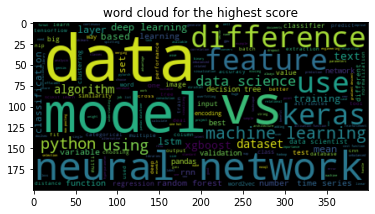

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
highest_score = TreebankWordDetokenizer().detokenize(highest_tokens)
wordcloud_highest = WordCloud().generate(highest_score)

plt.figure()
plt.imshow(wordcloud_highest, interpolation="bilinear")
plt.title('word cloud for the highest score')
plt.show()


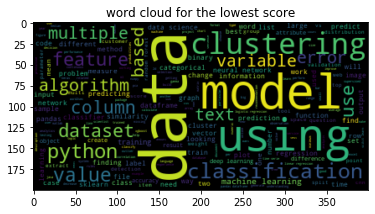

In [ ]:
lowest_score = TreebankWordDetokenizer().detokenize(lowest_tokens)
wordcloud_lowest = WordCloud().generate(lowest_score)

plt.figure()
plt.imshow(wordcloud_lowest, interpolation="bilinear")
plt.title('word cloud for the lowest score')
plt.show()

As you can see, data is the biggest appearing word. Like **BIG DATA**! Haha, get it?

Sorry kids, I'm tired. 

## Extra Credit : Completely optional - for the showoffs (i.e. the Vatsals) 
* An open ended extra credit - you can receive upto 5 additional points for this question.

The question requires you to build an XML/HTML code which looks like the original stackexchange webpage for any Post using the datasets we have provided.
* We will also load few other files below for your use, in case you want to use them to enhance your solution.
* A good start would be to see this [stack exchange url](https://datascience.stackexchange.com/questions/65740/about-the-maximum-likelihood-when-we-convert-the-maximization-problem-into-mini/65742#65742) and try to build a similar web page.
* In case you are not familiar with HTML, you can submit an XML with proper tree representation of the Posts, Comments, UpVotes, DownVotes, Score etc.
* As this is an Extra Credit Question, we will grade you on how well you use the datasets to present the data in HTML/ XML code and also how well you capture the Entity relationships between different relations(tables).

In [ ]:
# Your code here

#Section 2: Spark, Hierarchical Data and Graph Data on Yelp Reviews Dataset

## Getting Started with Apache Spark

Apache Spark, which has become the de facto successor to Apache Hadoop, is a complex, cluster-based data processing system that was written in Scala.  It leverages a wide variety of distributed tools and components used for big data processing.  It interfaces “smoothly” to Python, but be forewarned that there are some rough edges.  For those interested in why, there are a few reasons:

* Scala has slightly different notions of types (especially things like Rows) and handles missing values (nulls) differently from Python.
* The Scala-based Spark “engine” can’t just run Python functions as it’s doing data processing.  This means that you want to be careful to use Spark’s library of functions, or the special mechanisms for inserting “user defined functions.”
* DataFrames on Spark are “sharded,” so there is no single object corresponding to the DataFrame!

While Spark DataFrames try to emulate the same programming style as Pandas DataFrames, there are some differences in how you express things.  Please refer to the Lecture Slides for our take on the differences.  You may also find the following Web pages to be useful resources for understanding Spark vs Pandas DataFrames:

https://lab.getbase.com/pandarize-spark-dataframes/
https://ogirardot.wordpress.com/2015/07/31/from-pandas-to-apache-sparks-dataframe/ 

For this assignment, we are going to get familiar with Spark without worrying too much about sharding and distribution.  We are going to run Spark on your Docker container.  This isn’t really using it to its strengths -- and in fact you might find Spark to be unexpectedly slow -- but it will get you comfortable with programming in Spark without worrying about distributed nodes, clusters, and spending real dollars on the cloud.  Your code, if written properly, will “naturally scale” to clusters running on the Cloud.  Later in the term we’ll connect your Jupyter instance to Spark running on the cloud -- to handle “truly big data.”


### Initializing a Connection to Spark

We'll open a connection to Spark as follows. Note that Spark has multiple interfaces, as you will see if you look at sample code elsewhere. `SparkSession` is the “most modern” one and we’ll be using it for this course.  From `SparkSession`, you can load data into Spark DataFrames as well as `RDD`s.

Run the follow cells to setup the notebook!

In [ ]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  comerr-dev krb5-multidev libcom-err2 libgssrpc4 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
The following packages will be upgraded:
  libcom-err2
1 upgraded, 7 newly installed, 0 to remove and 24 not upgraded.
Need to get 358 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcom-err2 amd64 1.44.1-1ubuntu1.3 [8,848 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ub

In [ ]:
!apt update
!apt install gcc python-dev libkrb5-dev

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [83.6 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelea

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('Graphs-HW2').getOrCreate()


In [ ]:
%load_ext sparkmagic.magics

In [ ]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter

# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)


### Download data

The following code retrieves the Yelp dataset files from Google Drive.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1jR4-HUggivCewuhqqK6KRwRkU9QAMYKi',
                                    dest_path='/content/yelp_business_attributes.csv')

gdd.download_file_from_google_drive(file_id='1AWpo559vjl0EY59VgriYU0PoAgYKOpsD',
                                    dest_path='/content/yelp_business.csv')

gdd.download_file_from_google_drive(file_id='1AhgY2UovM3pDDr3BMTS2TVvNGq2yVRw2',
                                    dest_path='/content/yelp_checkin.csv')

gdd.download_file_from_google_drive(file_id='1uvLJQCbDd-pJkpupFjHdV6aKvhdUftQj',
                                    dest_path='/content/yelp_review2.csv')

gdd.download_file_from_google_drive(file_id='1YVr8Te2VafIBKmfQQQdOZIgw-mbcOdyN',
                                    dest_path='/content/yelp_user.csv')

## Part 4:

### 4.1 Load Our Graph Datasets.

For this assignment, we’ll be looking at graph data (reviews, reviewers, businesses) downloaded from Yelp.

**A very brief review of graph theory**. Recall that a graph $G$ is composed of a set of vertices $V$ (also called nodes) and edges $E$ (sometimes called links).  Each vertex $v \in V$ has an identity (often represented in the real world as a string or numeric “node ID”).  Each edge $e \in E$ is a tuple $(v_i,v_j)$ where $v_i$ represents the source or origin of the edge, and $v_j$ represents the target or destination.  In the simplest case, the edge tuple above is simply the pair $(v_i,v_j)$ but in many cases we may have additional fields such as a label or a distance.  Recall also that graphs may be undirected or directed; in undirected graphs, all edges are symmetric whereas in directed graphs, they are not.  For instance, airline flights are directed, whereas Facebook friend relationships are undirected.

Let’s read our social graph data from Yelp, which forms a directed graph.  Here, the set of nodes is also not specified; the assumption is that the only nodes that matter are linked to other nodes, and thus their IDs will appear in the set of edges.  To load the file `input.txt` into a Spark DataFrame, you can use lines like the following.

```
# Read lines from the text file
input_sdf = spark.read.load('input.txt', format="text")
```

We’ll use the suffix `_sdf` to represent “Spark DataFrame,” much as we used `_df` to denote a Pandas DataFrame in Homework 1.  Load the various files from Yelp.

Your datasets should be named `yelp_business_sdf`, `yelp_business_attributes_sdf`, `yelp_check_in_sdf`, `yelp_reviews_sdf`, and `yelp_users_sdf`.

Submit the first 75 entries of the yelp_business_sdf to the autograder as a pandas dataframe by using the toPandas() function to convert it from a spark dataframe to a normal dataframe. Also,
 make sure to sort it by the "name" column in ascending order

In [ ]:
yelp_business_attributes_sdf = spark.read.load('/content/yelp_business_attributes.csv', format="csv", header = True)
yelp_check_in_sdf = spark.read.load('/content/yelp_checkin.csv', format="csv", header = True)
yelp_reviews_sdf = spark.read.load('/content/yelp_review2.csv', format="csv", header = True)
yelp_users_sdf = spark.read.load('/content/yelp_user.csv', format="csv", header = True)

yelp_business_sdf = spark.read.load('/content/yelp_business.csv', format="csv", header = True)
yelp_business = yelp_business_sdf.toPandas().sort_values(by='name')
yelp_business

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
87368,aIq4Qxwr14JeQWYqbc5-5g,"""""""T""""s Hair Affair""",None,"1445 S Arizona Ave, Ste 107",Chandler,AZ,85286,33.2852706909,-111.840606689,5.0,10,1,Hair Salons;Men's Hair Salons;Beauty & Spas
108191,VguLzEEk7NOT9ec90NTcSQ,"""2 """"Di"""" 4 Gourmet Karmel Korn""",None,"765 N 114th Ave, Ste 105",Avondale,AZ,85323,33.4535199,-112.3051208,5.0,7,1,Food;Popcorn Shops;Specialty Food;Bridal;Gift ...
13630,KE7Uq1iXOQVhsPIzE800Aw,"""Au """"Grottens"""" Cafe & Catering""",None,2973 South Park Rd,Bethel Park,PA,15102,40.327322,-80.042015,4.5,3,1,American (New);Restaurants;Breakfast & Brunch
14675,4KGTPxWJ9-62_bdYMMTFvQ,"""Babies """"R"""" Us""",None,4835 E Ray Rd,Phoenix,AZ,85044,33.3173981537,-111.978713957,2.5,32,1,Shopping;Baby Gear & Furniture
32180,K3hLrL9WHjG_L7erRzBL8Q,"""Babies""""R""""Us""",None,510 N Stephanie St,Henderson,NV,89014,36.0597013,-115.0439191,3.5,29,1,Baby Gear & Furniture;Shopping;Toy Stores
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62157,sARavfidmIS878q5BtlyVQ,é by José Andrés,The Strip,3708 Las Vegas Blvd S,Las Vegas,NV,89109,36.109995716,-115.173604488,4.5,322,1,Restaurants;Spanish;Nightlife;Wine Bars;Seafoo...
32628,p1FPUxkQfSFqJGIkrF4abg,épicerie fine,None,Olgastr. 136,Stuttgart,BW,70180,48.76563,9.17676,5.0,19,1,Delicatessen;French;Restaurants;Food
56559,iy-iY6oTECXRLmcegylyKg,Œuf et Bœuf,Rosemont-La Petite-Patrie,3100 Rue Masson,Montréal,QC,H1Y 1X8,45.54922,-73.5741848,4.0,24,1,Restaurants;Breakfast & Brunch;Soup
78899,A8MaN_aloh6bAlVf2Zijkg,Œufs & Cie,None,8840 Boulevard Leduc,Brossard,QC,J4Y 0G4,45.450053,-73.442742,3.0,11,1,American (Traditional);Breakfast & Brunch;Rest...


In [ ]:
grader.grade(test_case_id = 'check_yelp_load', answer = yelp_business[:75])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Put your spark dataframes from the previous section into temporary tables. The syntax is as follows:

yelp_business_sdf.createOrReplaceTempView('yelp_business')

In [ ]:
yelp_business_sdf.createOrReplaceTempView('yelp_business')

### 4.2 Simple Analytics on the Data

In this section, we shall be executing Spark operations on the data given. Beyond simply executing the queries, you may try using `.explain()` method to see more about the query execution. Also, please read the data description prior to attempting the following questions to understand the data.


Compute, stored in `best_average_sdf`, the list of names of businesses based on their average review score (review stars), in decreasing order, sorted lexicographically (in increasing order) by name if they have the same score.  Output the number of reviews also.  Call the columns `name`, `avg_rating`, and `count`.

Convert this to pandas and submit the first 75 rows 

In [ ]:
best_average_sdf = spark.sql('SELECT name, stars, review_count FROM yelp_business ORDER BY stars DESC, name ASC')
best_average_sdf_75 = best_average_sdf.toPandas()[0:75]
best_average_sdf_75.rename(columns = {'stars':'avg_rating', 'review_count':'count'}, inplace = True) 
best_average_sdf_75

,name,avg_rating,count
0,"""""""T""""s Hair Affair""",5.0,10
1,"""2 """"Di"""" 4 Gourmet Karmel Korn""",5.0,7
2,"""Davis """"N"""" Sons Car Detailing""",5.0,4
3,"""Manantial De Salud """"The Vitamin Store""""""",5.0,3
4,"""Scotty""""s Kitchen""",5.0,3
...,...,...,...
70,24 Hours of Booty,5.0,5
71,24-7 Electrical Services,5.0,124
72,24-7 JB Services Garage Door,5.0,47
73,24/7 Carpet & Floor Care,5.0,53


In [ ]:
grader.grade(test_case_id = 'best_average_sdf_check', answer = best_average_sdf_75)

Correct! You earned 7/7 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 4.2.1 Users who are more negative than average

Find the users whose average review is below the *average of the per-user* average reviews.  Think about how to factor that into steps!

* Compute the (floating-point) variable `overall_avg` as the average of the users' average reviews. (You might compute this in a Spark DataFrame first).
* Then output `negative_users_sdf` as the users whose average rating is below that.  This Spark dataframe should have `name` and `avg_rating` and should be sorted first (from lowest to highest) by average rating, then lexicographically (in ascending order) by name.  You should drop cases where the name is null.

Submit just the overall_avg number that you get to the autograder as a float


In [ ]:
yelp_business_sdf.createOrReplaceTempView('yelp_business')

In [ ]:
yelp_users_sdf.createOrReplaceTempView('yelp_users')

from pyspark.sql.functions import mean, col
overall_avg = yelp_users_sdf.select(mean(col('average_stars')).alias('mean')).collect()
overall_avg = overall_avg[0]['mean']

negative_users_sdf = spark.sql('SELECT name, average_stars AS avg_rating FROM yelp_users WHERE average_stars < 3.71 AND name IS NOT NULL ORDER BY average_stars DESC, name ASC')
negative_users_sdf.show(10)

+-----+----------+
| name|avg_rating|
+-----+----------+
|6Kras|       3.7|
|    A|       3.7|
|    A|       3.7|
|    A|       3.7|
|    A|       3.7|
|    A|       3.7|
|    A|       3.7|
|    A|       3.7|
|    A|       3.7|
|    A|       3.7|
+-----+----------+
only showing top 10 rows



In [ ]:
grader.grade(test_case_id = 'check_avg', answer = overall_avg)

Correct! You earned 7/7 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 4.2.2 Cities by number of businesses

Find the top 10 cities by number of (Yelp-listed) businesses.

This time, use the `take()` function to create a *list* of the top 10 cities (as Rows).  Call this list `top10_cities` and make sure it includes city `name` and `num_restaurants`.

We want to answer as a list of lists where each element is the combination of the city name + num_restaurants:

[["Philadelphia", 12345], ["Los Angeles", 543]]

In [ ]:
top10_cities = spark.sql('SELECT city AS name, COUNT(*) AS num_restaurants FROM yelp_business GROUP BY city ORDER BY COUNT(*) DESC').take(10)

final = [] 
for row in top10_cities:
  final.append([row['name'], row['num_restaurants']])

final

[['Las Vegas', 26775],
 ['Phoenix', 17213],
 ['Toronto', 17206],
 ['Charlotte', 8553],
 ['Scottsdale', 8228],
 ['Pittsburgh', 6355],
 ['Mesa', 5760],
 ['Montréal', 5709],
 ['Henderson', 4465],
 ['Tempe', 4263]]

In [ ]:
grader.grade(test_case_id = 'top10CitiesCheck', answer = final)

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


The following is code we have given you. This builds a relationship graph thaat will be used in the next section. Take a look at it to familiarize yourself with it for the next section

In [ ]:
yelp_reviews_sdf.createOrReplaceTempView('yelp_reviews')
review_graph_sdf = spark.sql("SELECT user_id AS from_node, business_id AS to_node, stars AS score FROM yelp_reviews "\
                        "WHERE business_id is not null "\
                        "AND user_id is not null")
review_graph_sdf.createOrReplaceTempView('review_graph')


## Part 5. “Traversing” a Graph

For our next tasks, we will be “walking” the graph and making connections.




### 5.1 Distributed Breadth-First Search
A search algorithm typically starts at a node or set of nodes, and “explores” or “walks” for some number of steps to find a match or a set of matches.

If you need an introduction for BFS, I highly suggest looking here: https://www.tutorialspoint.com/data_structures_algorithms/breadth_first_traversal.htm

We will be asking for something slightly different tho...

Let’s implement a distributed version of a popular algorithm, breadth-first-search (BFS).  This algorithm is given a graph `G`, a set of origin nodes `N`, and a depth `d`.  In each iteration or round up to depth `d`, it explores the set of all new nodes directly connected to the nodes it already has seen, before going on to the nodes another “hop” away.  If we do this correctly, we will explore the graph in a way that (1) avoids getting caught in cycles or loops, and (2) visits each node in the fewest number of “hops” from the origin.  BFS is commonly used in tasks such as friend recommendation in social networks.

**How does distributed BFS in Spark work**?  Let’s start with a brief sketch of standard BFS.  During exploration “rounds”, we can divide the graph into three categories:

1. *unexplored nodes*.  These are nodes we have not yet visited.  You don’t necessarily need to track these separately from the graph.
2. *visited nodes*.  We have already reached these nodes in a previous “round”.
3. *frontier nodes*.  These are nodes we have visited in this round.  We have not yet checked whether they have out-edges connecting to unexplored nodes.

Let’s look at the figure, which shows a digraph.  The green node A represents the origin.

<p align = "center">
<img src = "https://imgur.com/WU3AUwg.png" width= "600" align ="center"/>

* In the first round, the origin A is the sole frontier node.  We find all nodes reachable directly from A, namely B-F; then we remove all nodes we have already visited (there are none) or that are in the frontier (the node A itself).  This leaves the blue nodes B-F, which are all reachable in (at most) 1 hop from A.
* In the second round, we move A to the visited set and B-F to the frontier.  Now we explore all nodes connected directly to frontier nodes, namely A (from B), F (from E), and the red nodes G-L.  We eliminate the nodes already contained in the frontier and visited sets from the next round’s frontier set, leaving the red nodes only.
* In the third round, we will move B-F to the visited set, G-L to the frontier set, and explore the next round of neighbors N-V.  This process continues up to some maximum depth (or until there are no more unexplored nodes).

Assume we create data structures (we can make them DataFrames) for the visited and frontier nodes.  Consider (1) how to initialize the different sets at the start of computation (note: unexplored nodes are already in the graph), and (2) how to use the graph edges and the existing data structures to update state for the next iteration “round”.

You might possibly have seen how to create a breadth-first-search algorithm in a single-CPU programming language, using a queue to capture the frontier nodes. With Spark we don’t need a queue -- we just need the three sets above.

### 5.2 Breadth-First Search Algorithm

Create a function `spark_bfs(G, origins, max_depth)` that takes a Spark DataFrame with a graph G (following the schema for `review_graph_sdf` described above, but to be treated as an **undirected graph**), a Python list-of-dictionaries `origins` of the form 

```
[{‘node’: nid1}, 
 {‘node’: nid2}, 
 …]
```

and a nonnegative integer “exploration depth” `max_depth` (to only run BFS on a tractable portion of the graph).  The `max_depth` will be the maximum number of edge traversals (e.g., the origin is at `max_depth=0`, one hop from the origin is `max_depth=1`, etc.  The function should return a DataFrame containing pairs of the form (node, distance), where the distance is depth at which $n$ was *first* encountered (i.e., the shortest-path distance from the origin nodes).  Note that the origin nodes should also be returned in this Spark DataFrame (with depth 0)!  

You can create a new Spark DataFrame with an integer `node` column from the above list of maps `origins`, as follows. This will give you a DataFrame of the nodes to start the BFS at

```
schema = StructType([
            StructField("node", StringType(), True)
        ])

    my_sdf = spark.createDataFrame(my_list_of_maps, schema)
```

In this algorithm, be careful in each iteration to keep only the nodes with their shortest distances (you may need to do aggregation or item removal).  You should accumulate all nodes at distances 0, 1, ..., `max_depth`.

In [ ]:
def spark_bfs(G, origins, max_depth):
  schema = StructType([
              StructField("node", StringType(), True),
              StructField("distance", IntegerType(), False)
          ])
  
  G = G.select("from_node", "to_node")
  _G = G
  _G = _G.withColumnRenamed("from_node","to").withColumnRenamed("to_node","from_node").withColumnRenamed("to","to_node")
  _G = _G.select("from_node","to_node") 
  G_total = G.union(_G)

  frontier_sdf = spark.createDataFrame([(origins[0]['node'],0)], schema)
  visited_sdf = spark.createDataFrame([(origins[0]['node'],0)], schema)
  
  depth = 0

  while depth < max_depth:
    result_sdf = frontier_sdf.join(G_total, frontier_sdf.node == G_total['from_node']).select(col('to_node').alias('node'), (col('distance')+1).alias('distance'))
    frontier_sdf = result_sdf
    visited_sdf = visited_sdf.union(result_sdf)
    depth +=1
  
  visited_sdf = visited_sdf.groupBy('node').agg(F.min('distance').alias('distance'))
  return visited_sdf

In [ ]:
simple = [('A', 'B'),
         ('A', 'C'),
         ('A', 'D'),
         ('C', 'F'),
         ('B', 'G'),
         ('G', 'H'),
         ('D', 'E')]
data = {'from_node': ['A', 'A', 'A', 'C', 'B', 'G', 'D'],
       'to_node': ['B', 'C', 'D', 'F', 'G', 'H', 'E']}
uh = pd.DataFrame.from_dict(data)
uh_sdf = spark.createDataFrame(uh)
smallOrig = [{'node': 'C'}]

smallCount = spark_bfs(uh_sdf, smallOrig, 3)

This is the starting origin node ID for your BFS and the associated call

In [ ]:
orig = [{'node': 'bv2nCi5Qv5vroFiqKGopiw'}]
#grab the count
count = spark_bfs(review_graph_sdf, orig, 3)
count.count()

13603

In [ ]:
answer_75 = count.orderBy("node")
answer_75 = answer_75.toPandas()[0:75]

When submitting to the autograder, submit as a tuple where first value is the length of your output dataframe and the second is the first 75 rows of your result.

However, before you grabb your first 75 rows, sort by the ids

In [ ]:
#13603 is just obtained from running count.count()
grader.grade(test_case_id = 'checkBFS', answer = (13603, answer_75))

Correct! You earned 17/17 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# HW Submission

**Double check that you have the correct PennID (all numbers) in the autograder**. 

Go to the "File" tab at the top left, and click "Download .ipynb". Zip it (name doesn't matter) and submit it to OpenSubmit. 

You must submit your notebook to receive credit.

**On OpenSubmit, go to Settings and make sure to set your Student ID to your PennID (all numbers)**.